#1 Introduction

Team Name: Supernova

Team Member: DENG Xindi, HUANG Raoyi, WANG Hewei

This is our solution for Kaggle's House Prices Prediction Competition. The rank of our team is shown below.

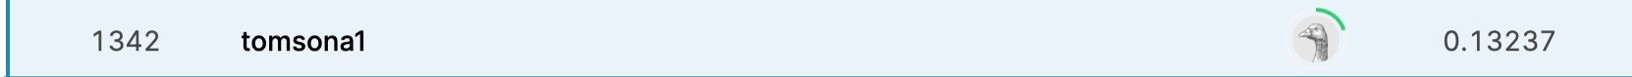

We divided this problem into four parts and we solved it in three stages.

Four parts:
1. data exploration
2. data preprocessing
3. feature engineering
4. model selection 

Three stages: 
1. Run a baseline model 

  After completing the data exploration and data preprocessing, we don't do the feature selection and run a simplest model. We take this model as a baseline.
2. Ajdust the feature engineering

  With the baseline model in stage 1, we can apply different strategies of feature selection and see how much each strategy can improve the performance of the model.
3. Ajdust the model selection 

  After doing the feature selection in stage 2, we already have relatively fixed data and features. Then we can apply model selection stragegies and run more sophisticated models. Finally, we can select the model with best performance.


#Load Package

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2 Data Exploration

## 2.1 Data Overview

Read the training dataset and testing dataset from the csv files. 

Since "ID" is a useless column, we do not consider it as an attribute and remove this column.

In [ ]:
path = "/content/drive/My Drive/COMP4433_Group Project"

train = pd.read_csv(path+'/train.csv')
train = train.drop(columns=['Id'])

test = pd.read_csv(path+'/test.csv')
test = test.drop(columns=['Id'])

sample = pd.read_csv(path+'/sample_submission.csv')
sample = sample.drop(columns=['Id'])

In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
train.shape

(1460, 80)

In [ ]:
test.shape

(1459, 79)

Training dataset has 1460 lines with 80 attributes (except "ID").

Testing dataset has 1459 lines with 79 attributes (except "ID").

In general, the model may make reliable predictions are made if the predictors and the target variable are normally distributed. Thus, we check the skewness of the sale price.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


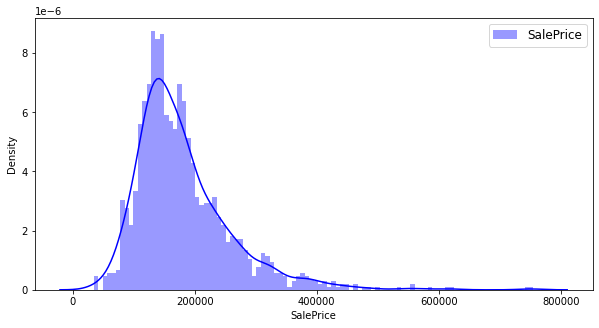

In [ ]:
# plot salesprices distribution

plt.subplots(figsize = (10, 5))
sns.distplot(train['SalePrice'].dropna(), kde = True, label = 'SalePrice', color = 'blue', bins = 100)
plt.legend(prop = {'size': 12})
plt.show()

We find that the SalePrice is right skewness. To make better prediction, we need try to smooth the curves for this skewed dataset in the part of data preprocessing, to see whether the smoothing can make some benefits in our model.

Reference: https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45

## 2.2 Exploration by mannual observation

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

After looing at the training dataset in more detail, we have three obvious observations.

1. Data type:  The main data types are object，float64 and int64. That means there are both categorical features and numerical features in our dataset.

2. Missing value: For some features, non-null values are less than 1460 (the total number of lines in train dataset), thus, there are missing values for some features.

3. Attribute name: The names of some features have the same prefix, which means these features are relating to the same object and may have higher correlation compared with others.

Based on these observations, we make further analysis to conclude how these observations can attribute to our model.

###2.2.1 Numerical & categorical features

Because of the difference beween the numerical features and categorical features, we may need to manipulate these two kinds of feautres seperately in some of the following parts. Thus, we seperate numerical features and categorical features to do the preparation for data preprocessing and feature selection.

In [ ]:
numerical_features = train.select_dtypes(exclude='object').columns
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [ ]:
len(numerical_features)

37

In [ ]:
categorical_features = train.select_dtypes(include='object').columns
categorical_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [ ]:
len(categorical_features)

43

### 2.2.2 Missing values

In [ ]:
missing = train.isnull().sum()
missing = missing[missing>0]
missing

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [ ]:
len(missing)

19

In [ ]:
missing_categorical = [i for i in missing.index if i in categorical_features]
missing_categorical

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [ ]:
len(missing_categorical)

16

In [ ]:
missing_numerical = [i for i in missing.index if i in numerical_features]
missing_numerical

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

There are totally 19 features (16 categorical features + 3 numerical features) have missing values. In data science, we try not to delete the data in order to retain as much useful information as possible. Thus, we will not directly delete the lines with missing values rather than fill in the values in the part of data preprocessing.

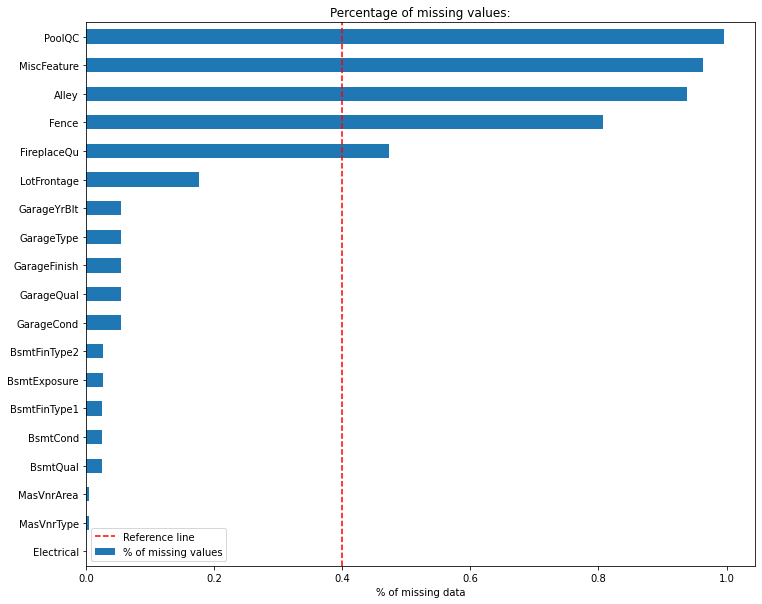

In [ ]:
import matplotlib.pyplot as plt

# percentage of missing values in each column
plt.figure(figsize = (12, 10))
(missing / train.shape[0]).sort_values().plot(kind = 'barh', label = '% of missing values')
plt.axvline(x = 0.4, color = 'r', linestyle = '--', label = 'Reference line')
plt.legend()
plt.title('Percentage of missing values:')
plt.xlabel('% of missing data')
plt.show()

Since we fill the missing values based on the current available data (similar to prediction), if
the percentage of current available data is low, i.e. less than 60 % (similar to training ratio 60%, testing ratio 40%),
it's better to discard the variables 

However, those 5 variables NA have their own meanings, but "read_csv" in "pandas" take "NA" in original dataset as a null. Thus, we need do more analysis in the following part and it's better not to remove at this time.


## 2.3 Exploration by computation

Besides exploring the data by manual observation, we can also do some explorations based on the help of computer computation.

###2.3.1 Descriptive statistics

In [ ]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


According to the descriptive statistics, we have two observations.

1. According to the mean values, we find that the values of some of the attributes are relatively large, and the values from two different attributes may have large difference.

2. According to the min values and the max values, the range of the values are within the control.

From Observation 1, we conclude that we need to do the data normalization to make the training more efficiently. From Observation 2, we conclude that Min-Max Normalization can be a candidate, for the min values and max values are not out-of-range.

###2.3.2 Correlation

In [ ]:
corrMatrix = train.corr()
corrMatrix

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.088011,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


After using descriptive statistics to observe the charateristic for each attribute, now we use correlation to explore the relationships among the numerical attributes and sale prices ("SalePrice"). With the help of visualization, the correlations can be observed more intuitively. 

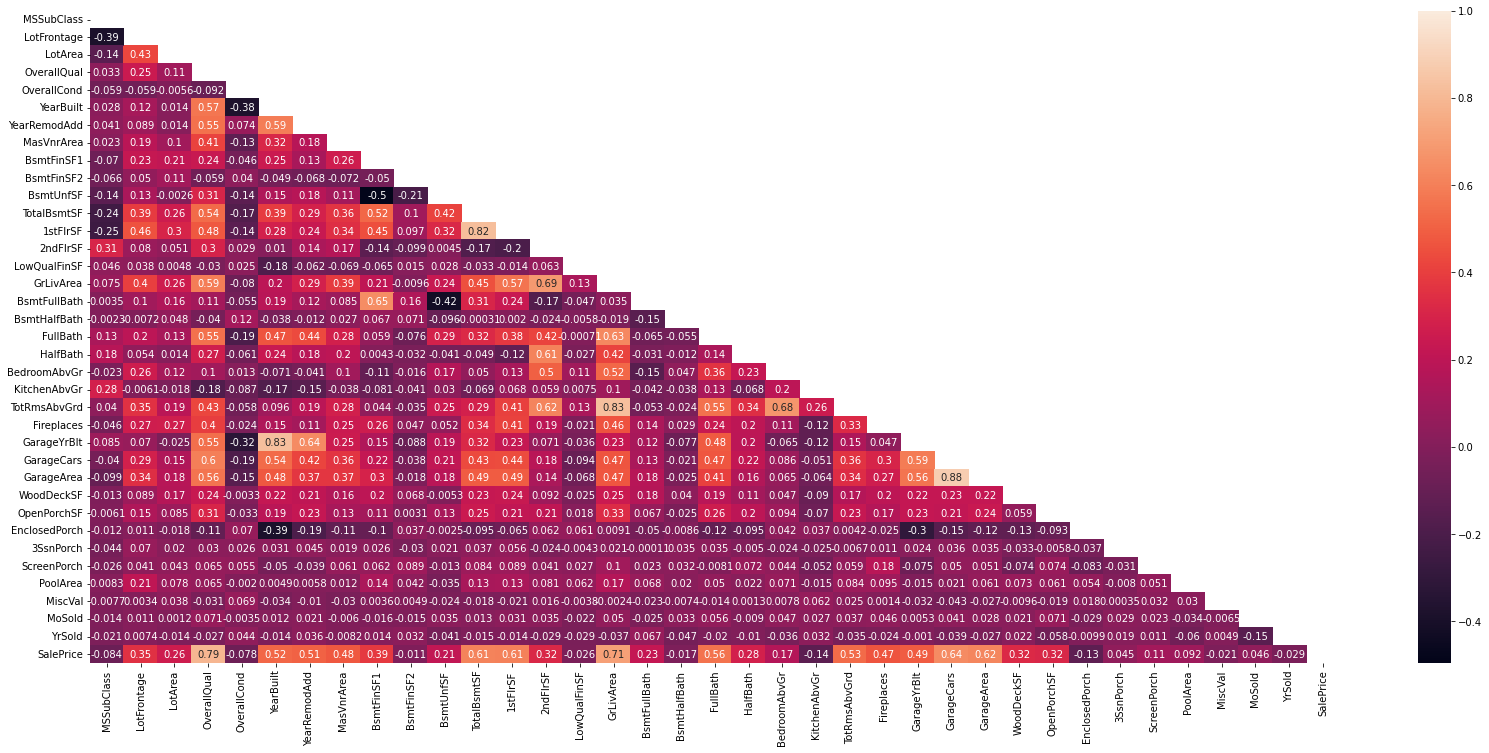

In [ ]:
import seaborn as sns

# correlation heatmap between all numerical features including the label

mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
# mask is an array of two lists [x1, x1, ..., x37] [y1, y2, ..., y37, y2, ...], represent the x
# and y coordinate values separately

plt.subplots(figsize=(28, 12))
sns.heatmap(corrMatrix, mask = mask, vmax = 1, square = False, annot = True)
plt.show()

Of which we can easily see some pairs of variables (features not labels) have correlation values > 0.8:

1. 0.88: GarageArea and GarageCars, easy to understand, 

  Size of garage in car capacity and in square feet (area in different units),both in dtype int, but the latter is probably more accurate since 1 foot approximately = 30.48 cm

2. 0.83: TotRmsAbvGrd and GrLivArea

  TotRmsAbvGrd: Total rooms above grade (does not include bathrooms), int

  GrLivArea: Above grade (ground) living area square feet, int
similarly living area approximately = area not include bathrooms,
but the latter is probably more accurate since 1 foot approximately = 30.48 cm

3. 0.83: GarageYrBlt and YearBuilt
  
  GarageYrBlt: Year garage was built
  
  YearBuilt: Original construction date 
  
  date when garage and house are built should be similar

4. 0.82: 1stFlrSF and TotalBsmtSF

  1stFlrSF: First Floor square feet
  
  TotalBsmtSF: Total square feet of basement area

  first floor is always for basement area, then they're likely to be similar

In [ ]:
# let's memorize these similar features to see what we can do later
similar_pairs = [['GarageArea', 'GarageCars'], ['TotRmsAbvGrd', 'GrLivArea'], ['GarageYrBlt', 'YearBuilt'], ['1stFlrSF', 'TotalBsmtSF']]

In [ ]:
np.triu_indices_from(mask)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6, 

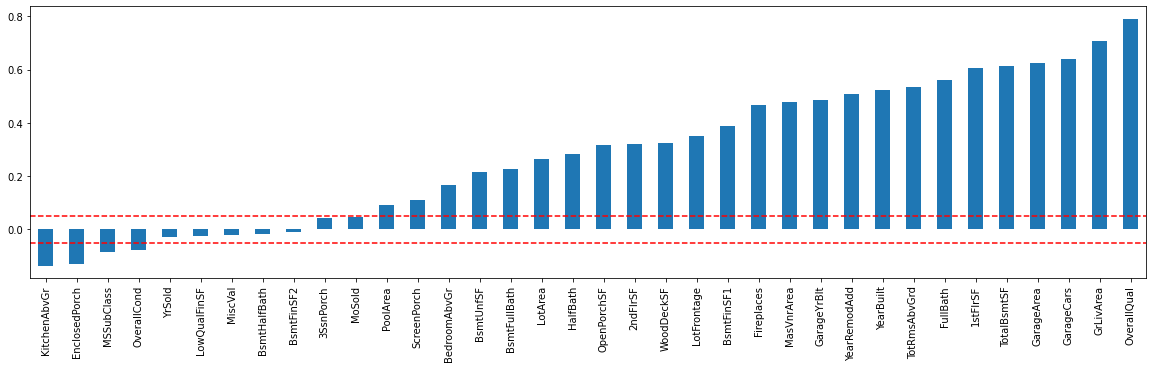

Amount of total features:  36
Amount of correlated features:  29


In [ ]:
# correlation heatmap between all numerical features and the label

plt.subplots(figsize = (20, 5))
corrMatrix['SalePrice'].drop(['SalePrice']).sort_values().plot(kind = 'bar')

plt.axhline(y = 0.05, color = 'red', linestyle = '--')
plt.axhline(y = -0.05, color = 'red', linestyle = '--')
plt.show()

#Correlation with output variable
cor_target = abs(corrMatrix['SalePrice'])

#Selecting correlated features
correlated_features = cor_target[cor_target >= 0.05]
# minus label
print('Amount of total features: ', corrMatrix.shape[0]-1)
print('Amount of correlated features: ', len(correlated_features)-1)

We choose 0.05 as a theshold of correlation for the features. According to the figure above, we find that there are 7 features that are below the theshold, which means these 7 features have very weak relation with the sale price. Thus, to reduce the workload of data preprocessing, we just remain the features with high correlation and remove the remaining features.

In [ ]:
correlated_features

MSSubClass       0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond      0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
GrLivArea        0.708624
BsmtFullBath     0.227122
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
SalePrice        1.000000
Name: SalePrice, dtype: float64

In [ ]:
not_correlated = [ i for i in numerical_features if i not in correlated_features]
not_correlated

['BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 '3SsnPorch',
 'MiscVal',
 'MoSold',
 'YrSold']

In [ ]:
# Let's remove the numeric variables with low correlation
train2 = train.drop(columns=not_correlated)

To visualized observe the degree to which each feature is related to house prices, visualisation of Y(saleprices) and X(each correlated numeric feature) is show below.

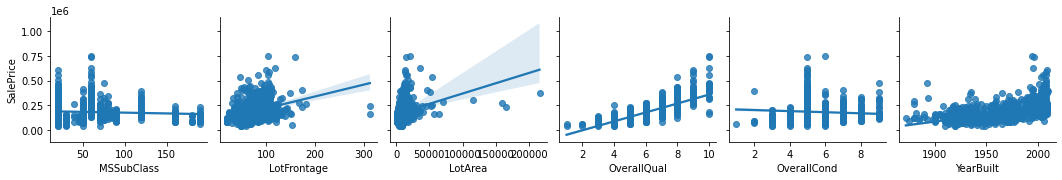

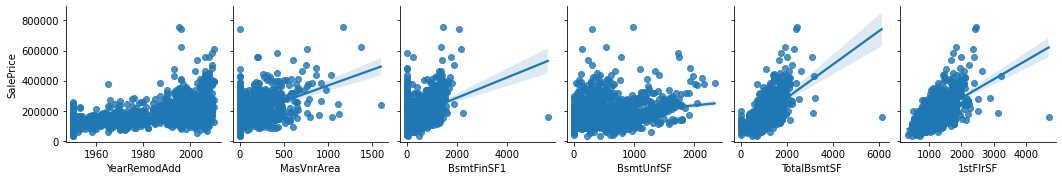

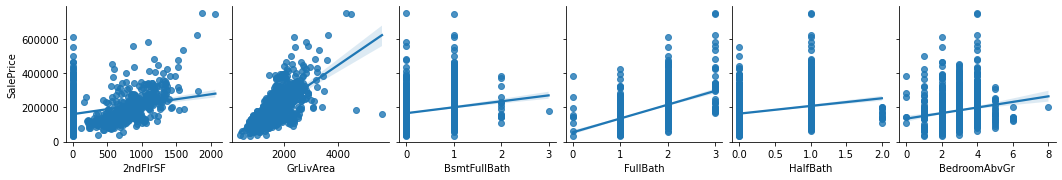

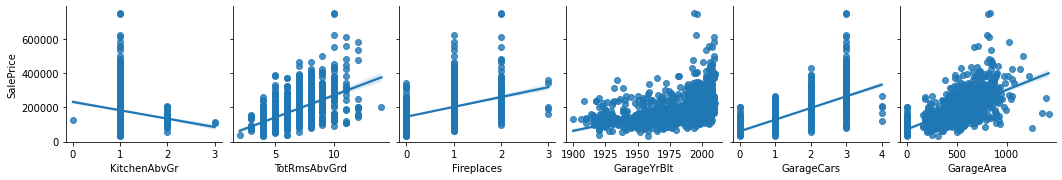

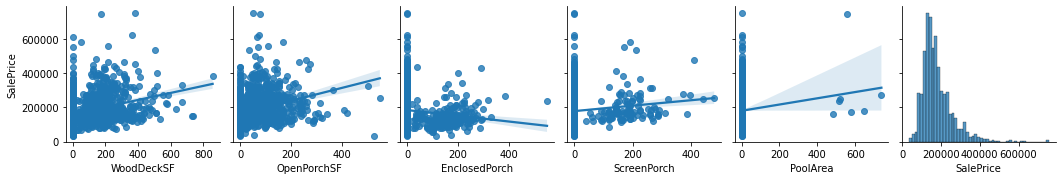

In [ ]:
# visualisation of Y(saleprices) and X(each correlated numeric feature)

for i in range(0, train2[correlated_features.index].shape[1], 6):
    sns.pairplot(data = train2[correlated_features.index.values],
                x_vars = train2[correlated_features.index].columns[i:i+6],
                y_vars = ['SalePrice'], kind='reg')
    
# we can see the trend is not that obvious

#3 Data Preprocessing

##3.1 Data Cleaning

###3.1.1 Remove outliers

According to the author of the dataset, "there are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points).
Reference: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

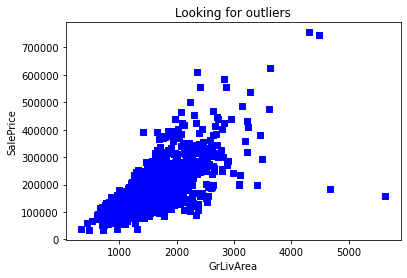

In [ ]:
plt.scatter(train2.GrLivArea, train2.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

According to the observation of the plot, the points with GrLivArea>4000 are outliers. Thus, we remove these points. 

In [ ]:
train2 = train2[train2.GrLivArea < 4000]

###3.1.2 Fill in missing values

Combine the train and test data for easy missing value filling.


In [ ]:
train_test = pd.concat([train2.drop(['SalePrice'], axis=1), test.drop(not_correlated, axis=1)]).reset_index()

In [ ]:
train_test=train_test.drop(columns=['index'])

In [ ]:
train_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,1710,1.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,NaN,NaN,NaN,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,1262,0.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,NaN,NaN,NaN,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,1786,1.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,NaN,NaN,NaN,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,1717,1.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,NaN,NaN,NaN,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,2198,1.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,NaN,NaN,NaN,WD,Normal


In [ ]:
train_test.shape

(2915, 72)

According to the previous observation, "NA" is a way to represent missing values. Before filling missing values, we need to check whether "NA" is the only representation of missing values in original dataset.

In [ ]:
# prove that 'NA' is the only pattern matches with read_csv the np_values,
# if we don't consider 'NA', then it should not exist any null value

patterns_notconsiderNA = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', 
                          '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null']
train_notconsiderNA = pd.read_csv(path+'/train.csv', keep_default_na=False, na_values = patterns_notconsiderNA)
test_notconsiderNA = pd.read_csv(path+'/test.csv', keep_default_na=False, na_values = patterns_notconsiderNA)

In [ ]:
m = train_notconsiderNA.isnull().sum()
m[m > 0]

Series([], dtype: int64)

In [ ]:
m = test_notconsiderNA.isnull().sum()
m[m > 0]

Series([], dtype: int64)

After taking "NA" as a string rather than a missing value, there is no other missing value in the dataset. Therefore, "NA" is the only way to represent missing values in this dataset.

In [ ]:
missingC = train_test.isnull().sum()
missingC = missingC[missingC > 0]
missingC

MSZoning           4
LotFrontage      486
Alley           2717
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2907
Fence           2345
MiscFeature     2810
SaleType           1
dtype: int64

In [ ]:
len(missingC)

32

After checking the document of data_description, we find that for quantitative attributes, "NA" refers to a missing value. However, for some qualititive attributes, "NA" is one of its candidate values rather than a missing value. Therefore, we manipulate the missing values of qualititive and quantitative attributes seperately.

**First, we manipulate the missing values for categorical features.**

In [ ]:
missingC_categorical = [i for i in missingC.index if i in categorical_features]
missingC[missingC_categorical]

MSZoning           4
Alley           2717
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2907
Fence           2345
MiscFeature     2810
SaleType           1
dtype: int64

In [ ]:
len(missingC_categorical)

23

We will make 'NA' for features not need to be filled (originally have some meanings as 'NA' in csv, but mistakenly treated as np.nan considering pd_read_csv functions to convert some patterns[including 'NA'] in csv to np.nan), and fill other values for those which need to be filled

Alley: NA - No alley access

BsmtQuaL, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2: NA - No Basement

FireplaceQu: NA - No Fireplace

GarageType, GarageFinish, GarageQual, GarageCond: NA - No Garage

PoolQC: NA - No Pool

Fence: NA - No Fence

MiscFeature: NA - None

MSZoning, Utilities, Exterior1st, Exterior2nd, KitchenQual, Functional, SaleType, MasVnrType, Electrical: NA - missing value








In [ ]:
categorical_features_notNeedFill = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

categorical_features_needFill = list(set(missingC_categorical)-set(categorical_features_notNeedFill))
categorical_features_needFill

['Electrical',
 'Exterior1st',
 'SaleType',
 'Functional',
 'Utilities',
 'MSZoning',
 'KitchenQual',
 'MasVnrType',
 'Exterior2nd']

In [ ]:
for i in missingC_categorical:
    train_test.replace({i: {np.nan: 'NA'}}, inplace=True)

For the not-need-fill features (i.e., features that take NA as a candidate), we use "NA" to fill the missing values.

In [ ]:
for i in categorical_features_needFill:
    train_test[i].replace('NA', train2[i].mode()[0], inplace=True)

For the need-fill features, we use mode in the training data to fill the missing values. Using mode is a simple way to deal with categorical missing values. We use this method because the number of missing values for these features are pretty small.

TODO: In the future, we will also try to use ARM and decision tree. 

**Second, we manipulate the missing values for numerical features.**

In [ ]:
missingC_numerical = [i for i in missingC.index if i in numerical_features]
missingC[missingC_numerical]

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [ ]:
len(missingC_numerical)

9

After observating the missing variables, we find that the features relating to the same object (i.e., the features have the same prefix) have similar numbers of missing values. Thus, I predict that the missing values of numerical variables are not random.

In [ ]:
attributes_list1 = ["MasVnrArea","LotFrontage","BsmtFinSF1","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","GarageYrBlt","GarageCars","GarageArea"]
attributes_list2 = ["MasVnrType","Alley","BsmtFinType1","BsmtCond","BsmtCond","BsmtCond","GarageType","GarageType","GarageType"]

list_match = train_test[train_test[attributes_list1[0]].isnull()][attributes_list2[0]]=="None"
if len(list_match)!=0:
    print(attributes_list1[0],": rate of NA matching -",sum(list_match)/len(list_match))

for i in range(1,len(attributes_list1)):
  list_match = train_test[train_test[attributes_list1[i]].isnull()][attributes_list2[i]]=="NA"
  if len(list_match)!=0:
    print(attributes_list1[i],": rate of NA matching -",sum(list_match)/len(list_match))

MasVnrArea : rate of NA matching - 1.0
LotFrontage : rate of NA matching - 0.9732510288065843
BsmtFinSF1 : rate of NA matching - 1.0
BsmtUnfSF : rate of NA matching - 1.0
TotalBsmtSF : rate of NA matching - 1.0
BsmtFullBath : rate of NA matching - 1.0
GarageYrBlt : rate of NA matching - 0.9874213836477987
GarageCars : rate of NA matching - 0.0
GarageArea : rate of NA matching - 0.0


As mentioned in the part of data exploration, we mentioned that there exists many features with similar meaning. For each numerical feature with missing value(s), we find one categorical feature that is about the same object as that numerical feature and take "NA" as a candidate ("NA" here means that the object does not exist). 

We assume that the reason why there are missing values is that the corresponding object does not exists, which decidedly leads to the null value for the parameters (i.e., numerical features relating to that object). We use "rate of NA matching" to check our assumption.

In [ ]:
train_test[train_test['GarageCars'].isnull()]['GarageType']

2572    Detchd
Name: GarageType, dtype: object

In [ ]:
train_test[train_test['GarageArea'].isnull()]['GarageType']

2572    Detchd
Name: GarageType, dtype: object

Since these two contradictions happens in test dataset (column id > 1454), we cannot remove the row and just assign 0 to these values.

In [ ]:
for i in attributes_list1:
  train_test.replace({i: {np.nan: 0}},inplace=True)

For the remaining 7 features, the assumption is acceptable for the rate is pretty high (>0.97). Thus, "NA" means object does not exist and we can directly use 0 to replace the missing values.

In [ ]:
m = train_test.isnull().sum()
m[m > 0]

Series([], dtype: int64)

All missing values are filled in.

In [ ]:
train3 = train_test[0: train2.shape[0]]
test3 = train_test[train2.shape[0]: ]

In [ ]:
train2 = train2.reset_index().drop(columns=['index'])

In [ ]:
train3 = pd.concat([train3, train2[['SalePrice']]], axis = 1)

In [ ]:
train3.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,1710,1.0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,NA,NA,NA,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,1262,0.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,NA,NA,NA,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,1786,1.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,NA,NA,NA,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,1717,1.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,NA,NA,NA,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,2198,1.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,NA,NA,NA,WD,Normal,250000


train3 is from train2 with missing values filled.

###3.1.3 Resolve inconsistence

In this dataset, there are several conditions that may cause data inconsistence.

1. In a tuple, the values of several attributes should have the same value because of their connections in the meaning but they don't. 
2. Two tuples have the same values for all attributes, but they contribute to different house prices. (does not exist this condition in this dataset)

First, consider the condition 1.

For some qualitative attributes, we use "NA" to represent the object does not exist in this tuple. For the objects, if they do not exist, they may simultaneously affect relating attributes in the same way. If the inexitence of one object does not affect all the relating attributes, there would be inconsistence.

We summarize the attributes that are relating to the same object.

1. Basement: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2. ( The "NA" for this five attributes is "No Basement". )
2. Garage: GarageType, GarageFinish, GarageQual, GarageCond ( The "NA" for this four attrivutes is "No Garage". )


In [ ]:
list_inconsistence = []

In [ ]:
for i in range(train3.shape[0]):
  list_NA1 = [train3.iloc[i]["BsmtQual"]=="NA", train3.iloc[i]["BsmtCond"]=="NA", train3.iloc[i]["BsmtExposure"]=="NA", train3.iloc[i]["BsmtFinType1"]=="NA", train3.iloc[i]["BsmtFinType2"]=="NA"]
  list_NA2 = [train3.iloc[i]["GarageType"]=="NA", train3.iloc[i]["GarageFinish"]=="NA", train3.iloc[i]["GarageQual"]=="NA", train3.iloc[i]["GarageCond"]=="NA"]
  if (any(list_NA1) and not all(list_NA1)) or ((any(list_NA2) and not all(list_NA2))):
    list_inconsistence.append(i)


In [ ]:
list_inconsistence

[332, 946]

There are two lines with contradictive values, thus we remove these two lines.

In [ ]:
train3 = train3.drop(list_inconsistence)
train3 = train3.reset_index().drop(columns=['index'])

In [ ]:
train3.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,1710,1.0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,NA,NA,NA,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,1262,0.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,NA,NA,NA,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,1786,1.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,NA,NA,NA,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,1717,1.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,NA,NA,NA,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,2198,1.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,NA,NA,NA,WD,Normal,250000


##3.2 Data Transformation

###3.2.1 Remove skewness

In [ ]:
train3.reset_index(drop=True, inplace=True)
train3["SalePrice"] = np.log1p(train3["SalePrice"])
y = train3['SalePrice'].reset_index(drop=True)

We use log transformation to remove the skewness. To avoid the dramatic variability in (0,1), we use log1p to do the transformation.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


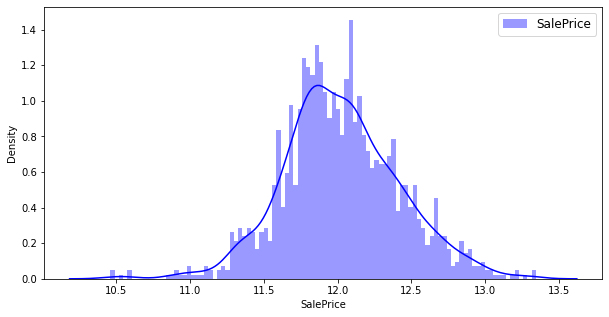

In [ ]:
plt.subplots(figsize = (10, 5))
sns.distplot(train3['SalePrice'].dropna(), kde = True, label = 'SalePrice', color = 'blue', bins = 100)
plt.legend(prop = {'size': 12})
plt.show()

After removing skewness, the curve is close to the curve of normal distribution.

###3.2.2 Categorical values -> Numerical values

Features with numerical representation is more convinient for the model training. Thus, to represent the categorical features, we transform all categorical values to numerical values with the use of Labelencoder.






In [ ]:
#from sklearn.preprocessing import LabelEncoder

train4 = train3.copy()
test4 = test3.copy()

#train4 is from train3 with categorical values to the numerical ones
#test4 is from test3 with categorical values to the numerical ones

encoder_label = pd.Series(dtype=pd.StringDtype()) # use encoder_label to store the correspondence between the qualitative values and its labels

for i in train4.select_dtypes(include='object').columns:
  le = preprocessing.LabelEncoder()
  train4[i] = le.fit_transform(train4[i])
  encoder_label[i] = list(le.classes_)
  test4[i] = le.transform(test4[i])


In [ ]:
encoder_label # the index of the list is the label of the corresponding qualitative values, e.g. [C(all), FV, RH, RL, RM] -> [0, 1, 2, 3, 4]

MSZoning                                 [C (all), FV, RH, RL, RM]
Street                                                [Grvl, Pave]
Alley                                             [Grvl, NA, Pave]
LotShape                                      [IR1, IR2, IR3, Reg]
LandContour                                   [Bnk, HLS, Low, Lvl]
Utilities                                         [AllPub, NoSeWa]
LotConfig                      [Corner, CulDSac, FR2, FR3, Inside]
LandSlope                                          [Gtl, Mod, Sev]
Neighborhood     [Blmngtn, Blueste, BrDale, BrkSide, ClearCr, C...
Condition1       [Artery, Feedr, Norm, PosA, PosN, RRAe, RRAn, ...
Condition2       [Artery, Feedr, Norm, PosA, PosN, RRAe, RRAn, ...
BldgType                     [1Fam, 2fmCon, Duplex, Twnhs, TwnhsE]
HouseStyle       [1.5Fin, 1.5Unf, 1Story, 2.5Fin, 2.5Unf, 2Stor...
RoofStyle               [Flat, Gable, Gambrel, Hip, Mansard, Shed]
RoofMatl         [CompShg, Membran, Metal, Roll, Tar&Grv, WdSh

In [ ]:
train4.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,0,12,13,1,196.0,2,4,2,2,4,4,2,706.0,6,150.0,856.0,1,0,1,4,856,854,1710,1.0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2.0,548.0,5,5,2,0,61,0,0,0,3,4,1,8,4,12.247699
1,20,3,80.0,9600,1,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,0,8,8,2,0.0,3,4,1,2,4,1,0,978.0,6,284.0,1262.0,1,0,1,4,1262,0,1262,0.0,2,0,3,1,3,6,6,1,5,1,1976.0,2,2.0,460.0,5,5,2,298,0,0,0,0,3,4,1,8,4,12.109016
2,60,3,68.0,11250,1,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,0,12,13,1,162.0,2,4,2,2,4,2,2,486.0,6,434.0,920.0,1,0,1,4,920,866,1786,1.0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2.0,608.0,5,5,2,0,42,0,0,0,3,4,1,8,4,12.317171
3,70,3,60.0,9550,1,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,0,13,15,2,0.0,3,4,0,4,1,4,0,216.0,6,540.0,756.0,1,2,1,4,961,756,1717,1.0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3.0,642.0,5,5,2,0,35,272,0,0,3,4,1,8,0,11.849405
4,60,3,84.0,14260,1,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,0,12,13,1,350.0,2,4,2,2,4,0,2,655.0,6,490.0,1145.0,1,0,1,4,1145,1053,2198,1.0,2,1,4,1,2,9,6,1,5,1,2000.0,2,3.0,836.0,5,5,2,192,84,0,0,0,3,4,1,8,4,12.429220


###3.2.3 Data nomorlization

In the part of data exploration, we conclude that Min-Max Normalization can be used to nomorlize the data, for the max value and min value of the data is within the control. And we normalized it to the range [0, 10] instead of the common [0, 1] (too small to see differences).

In [ ]:
train5=train4.copy()
test5=test4.copy()

In [ ]:
# it's better to use min-max normalizatiion if data not that normally distributed

for i in train5.drop(columns=['SalePrice']).columns:
  # scale to 0 to 1
  test5[i] = (test5[i] - train5[i].min())/(train5[i].max()-train5[i].min())*10
  train5[i] = (train5[i] - train5[i].min())/(train5[i].max()-train5[i].min())*10

In [ ]:
train5.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,2.352941,7.5,2.076677,0.334198,10.0,5.0,10.0,10.0,0.0,10.0,0.0,2.083333,2.50,2.857143,0.0,7.142857,6.666667,5.00,9.492754,8.833333,2.0,0.0,8.571429,8.666667,3.333333,1.2250,6.666667,10.0,4.0,5.0,10.0,10.0,3.333333,3.226691,10.0,0.642123,2.675000,2.0,0.0,10.0,10.0,1.803732,4.697470,4.178561,3.333333,6.666667,5.0,3.75,3.333333,6.666667,5.000000,10.0,0.000000,6.0,1.666667,9.965174,6.666667,5.0,3.942446,10.0,10.0,10.0,0.000000,1.115174,0.000000,0.0,0.0,10.0,10.0,2.5,10.0,8.0,12.247699
1,0.000000,7.5,2.555911,0.387950,10.0,5.0,10.0,10.0,0.0,5.0,0.0,10.000000,1.25,2.857143,0.0,2.857143,5.555556,8.75,7.536232,4.333333,2.0,0.0,5.714286,5.333333,6.666667,0.0000,10.000000,10.0,2.0,5.0,10.0,2.5,0.000000,4.469835,10.0,1.215753,3.943750,2.0,0.0,10.0,10.0,3.206634,0.000000,2.818099,0.000000,6.666667,0.0,3.75,3.333333,10.000000,3.333333,10.0,3.333333,10.0,1.666667,9.830846,6.666667,5.0,3.309353,10.0,10.0,10.0,3.477246,0.000000,0.000000,0.0,0.0,10.0,10.0,2.5,10.0,8.0,12.109016
2,2.352941,7.5,2.172524,0.465073,10.0,5.0,0.0,10.0,0.0,10.0,0.0,2.083333,2.50,2.857143,0.0,7.142857,6.666667,5.00,9.347826,8.666667,2.0,0.0,8.571429,8.666667,3.333333,1.0125,6.666667,10.0,4.0,5.0,10.0,5.0,3.333333,2.221207,10.0,1.857877,2.875000,2.0,0.0,10.0,10.0,2.024879,4.763476,4.409353,3.333333,6.666667,5.0,3.75,3.333333,6.666667,3.333333,10.0,3.333333,10.0,1.666667,9.955224,6.666667,5.0,4.374101,10.0,10.0,10.0,0.000000,0.767824,0.000000,0.0,0.0,10.0,10.0,2.5,10.0,8.0,12.317171
3,2.941176,7.5,1.916933,0.385613,10.0,5.0,0.0,10.0,0.0,0.0,0.0,2.500000,2.50,2.857143,0.0,7.142857,6.666667,5.00,3.115942,3.333333,2.0,0.0,9.285714,10.000000,6.666667,0.0000,10.000000,10.0,0.0,10.0,2.5,10.0,0.000000,0.987203,10.0,2.311644,2.362500,2.0,5.0,10.0,10.0,2.166551,4.158416,4.199818,3.333333,3.333333,0.0,3.75,3.333333,6.666667,4.166667,10.0,3.333333,4.0,8.333333,9.940299,10.000000,7.5,4.618705,10.0,10.0,10.0,0.000000,0.639854,4.927536,0.0,0.0,10.0,10.0,2.5,10.0,0.0,11.849405
4,2.352941,7.5,2.683706,0.605763,10.0,5.0,0.0,10.0,0.0,5.0,0.0,6.250000,2.50,2.857143,0.0,7.142857,7.777778,5.00,9.275362,8.333333,2.0,0.0,8.571429,8.666667,3.333333,2.1875,6.666667,10.0,4.0,5.0,10.0,0.0,3.333333,2.993601,10.0,2.097603,3.578125,2.0,0.0,10.0,10.0,2.802350,5.792079,5.660492,3.333333,6.666667,5.0,5.00,3.333333,6.666667,5.833333,10.0,3.333333,10.0,1.666667,9.950249,6.666667,7.5,6.014388,10.0,10.0,10.0,2.240373,1.535649,0.000000,0.0,0.0,10.0,10.0,2.5,10.0,8.0,12.429220


In [ ]:
test5.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
1456,0.000000,5.0,2.555911,0.482460,10.0,5.0,10.0,10.000000,0.0,10.0,0.0,5.000000,1.25,2.857143,0.0,2.857143,4.444444,6.25,6.449275,1.833333,2.0,0.0,8.571429,8.666667,6.666667,0.000,10.000000,10.0,2.0,10.0,10.0,10.0,8.333333,2.138940,5.0,1.155822,2.756250,2.0,10.0,10.0,10.0,1.941949,0.000000,1.706650,0.0,3.333333,0.0,2.50,3.333333,10.000000,2.500000,10.0,0.000000,6.0,1.666667,9.756219,10.000000,2.5,5.251799,10.0,10.0,10.0,1.633606,0.000000,0.0,2.5,0.0,10.0,5.0,2.5,10.0,8.0
1457,0.000000,7.5,2.587859,0.606090,10.0,5.0,0.0,10.000000,0.0,0.0,0.0,5.000000,2.50,2.857143,0.0,2.857143,5.555556,6.25,6.231884,1.333333,6.0,0.0,9.285714,9.333333,3.333333,0.675,10.000000,10.0,2.0,10.0,10.0,10.0,0.000000,4.218464,10.0,1.738014,4.153125,2.0,10.0,10.0,10.0,3.438148,0.000000,3.021561,0.0,3.333333,5.0,3.75,3.333333,6.666667,3.333333,10.0,0.000000,6.0,1.666667,9.741294,10.000000,2.5,2.244604,10.0,10.0,10.0,4.585764,0.658135,0.0,0.0,0.0,10.0,10.0,0.0,10.0,8.0
1458,2.352941,7.5,2.364217,0.585665,10.0,5.0,0.0,10.000000,0.0,10.0,0.0,3.333333,2.50,2.857143,0.0,7.142857,4.444444,5.00,9.057971,8.000000,2.0,0.0,8.571429,8.666667,6.666667,0.000,10.000000,10.0,4.0,5.0,10.0,10.0,3.333333,3.615174,10.0,0.586473,2.900000,2.0,5.0,10.0,10.0,2.052522,3.855886,3.932584,0.0,6.666667,5.0,3.75,3.333333,10.000000,3.333333,10.0,3.333333,10.0,1.666667,9.935323,0.000000,5.0,3.467626,10.0,10.0,10.0,2.473746,0.621572,0.0,0.0,0.0,10.0,5.0,2.5,10.0,8.0
1459,2.352941,7.5,2.492013,0.405618,10.0,5.0,0.0,10.000000,0.0,10.0,0.0,3.333333,2.50,2.857143,0.0,7.142857,5.555556,6.25,9.130435,8.000000,2.0,0.0,8.571429,8.666667,3.333333,0.125,10.000000,10.0,4.0,10.0,10.0,10.0,3.333333,2.751371,10.0,1.386986,2.893750,2.0,0.0,10.0,10.0,2.045612,3.729373,3.856666,0.0,6.666667,5.0,3.75,3.333333,6.666667,4.166667,10.0,3.333333,4.0,1.666667,9.940299,0.000000,5.0,3.381295,10.0,10.0,10.0,4.200700,0.658135,0.0,0.0,0.0,10.0,10.0,2.5,10.0,8.0
1460,5.882353,7.5,1.373802,0.173175,10.0,5.0,0.0,3.333333,0.0,10.0,0.0,9.166667,2.50,2.857143,10.0,2.857143,7.777778,5.00,8.695652,7.000000,2.0,0.0,4.285714,4.000000,6.666667,0.000,6.666667,10.0,4.0,5.0,10.0,10.0,0.000000,1.202011,10.0,4.353596,4.000000,2.0,0.0,10.0,10.0,3.268832,0.000000,2.872760,0.0,6.666667,0.0,2.50,3.333333,6.666667,2.500000,10.0,0.000000,6.0,1.666667,9.910448,6.666667,5.0,3.640288,10.0,10.0,10.0,0.000000,1.499086,0.0,3.0,0.0,10.0,10.0,2.5,10.0,8.0


Besides Min-Max Representation, z-score normalization is also a way to do data normalization. To check whether we can apply z-score normalization, we need to determine whether features are normally distributed.

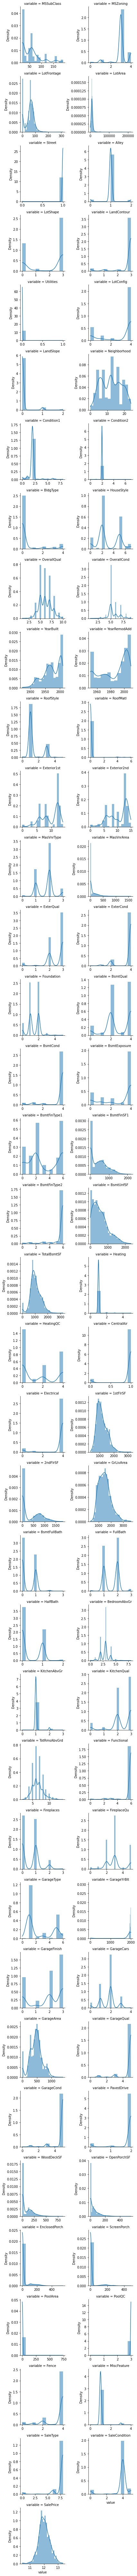

In [ ]:
# determine whether data are normally distributed (visualisation)

f = pd.melt(train4, value_vars=train4.columns)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.histplot, "value", kde=True, stat="density", linewidth=0)

According to the figures above, we find that most of the features are far from normally distribution. Thus, it is not applicable to use z-score normalization.

Till here, we complete the part of data preprocessing. We seperate training dataset and tesing dataset to make preparation for the later parts.

In [ ]:
train5.to_csv(path+'/Final_submission/Log1_train_p10.csv')

In [ ]:
test5.to_csv(path+'/Final_submission/Log1_test_p10.csv')